# Homework 1

### Installing packages

In [ ]:
!pip install langchain_google_genai


### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `VERTEX_API_KEY`.


1.   Look for the key icon on the left panel of your colab.
2.   Under `Name`, create `VERTEX_API_KEY`.
3. Copy your key to `Value`.




In [10]:
from google.colab import userdata
GEMINI_VERTEX_API_KEY = userdata.get('123')

### Downloading receipts.zip
The codes below download and unzip receipts.zip from Google Drive. There are only three images in zip file for illustration only.

You need to download all images in the files on Blackboard and upload to your Google Colab session. for evaluation.

In [5]:
import gdown
file_id = "1oe2FZd3ZTO7nrDqjCafNvxicl08oF8JF"
download_url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(download_url, "receipts.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oe2FZd3ZTO7nrDqjCafNvxicl08oF8JF
To: /content/receipts.zip
100%|██████████| 685k/685k [00:00<00:00, 101MB/s]


'receipts.zip'

In [6]:
!unzip receipts.zip

Archive:  receipts.zip
  inflating: receipt1.jpg            
  inflating: __MACOSX/._receipt1.jpg  
  inflating: receipt2.jpg            
  inflating: __MACOSX/._receipt2.jpg  
  inflating: receipt3.jpg            
  inflating: __MACOSX/._receipt3.jpg  


### 1. Helper functions

We need two functions
* image_to_base64 convert your jpg image into Base64 encoded string (basically a sequence of 64 characters to make your image easily transfered via API)
* get_image_data_url takes your jpg image, converting them into base64 string and construct a suitable input for GEMINI api call.

In [11]:
import base64
import mimetypes

# Helper function to read and encode image
def image_to_base64(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Helper function to encode local file to Base64 Data URL
def get_image_data_url(image_path):
    # Guess the mime type (e.g., image/png, image/jpeg) based on file extension
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        mime_type = "image/png" # Default fallback

    encoded_string = image_to_base64(image_path)

    # Construct the Data URL
    return f"data:{mime_type};base64,{encoded_string}"

In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=userdata.get('123'), # Ensure this key is set in Colab secrets
    temperature=0,
    vertexai=False
)

Display jpg images. Alternatively, open the folder icon on the left pannel to see the images.


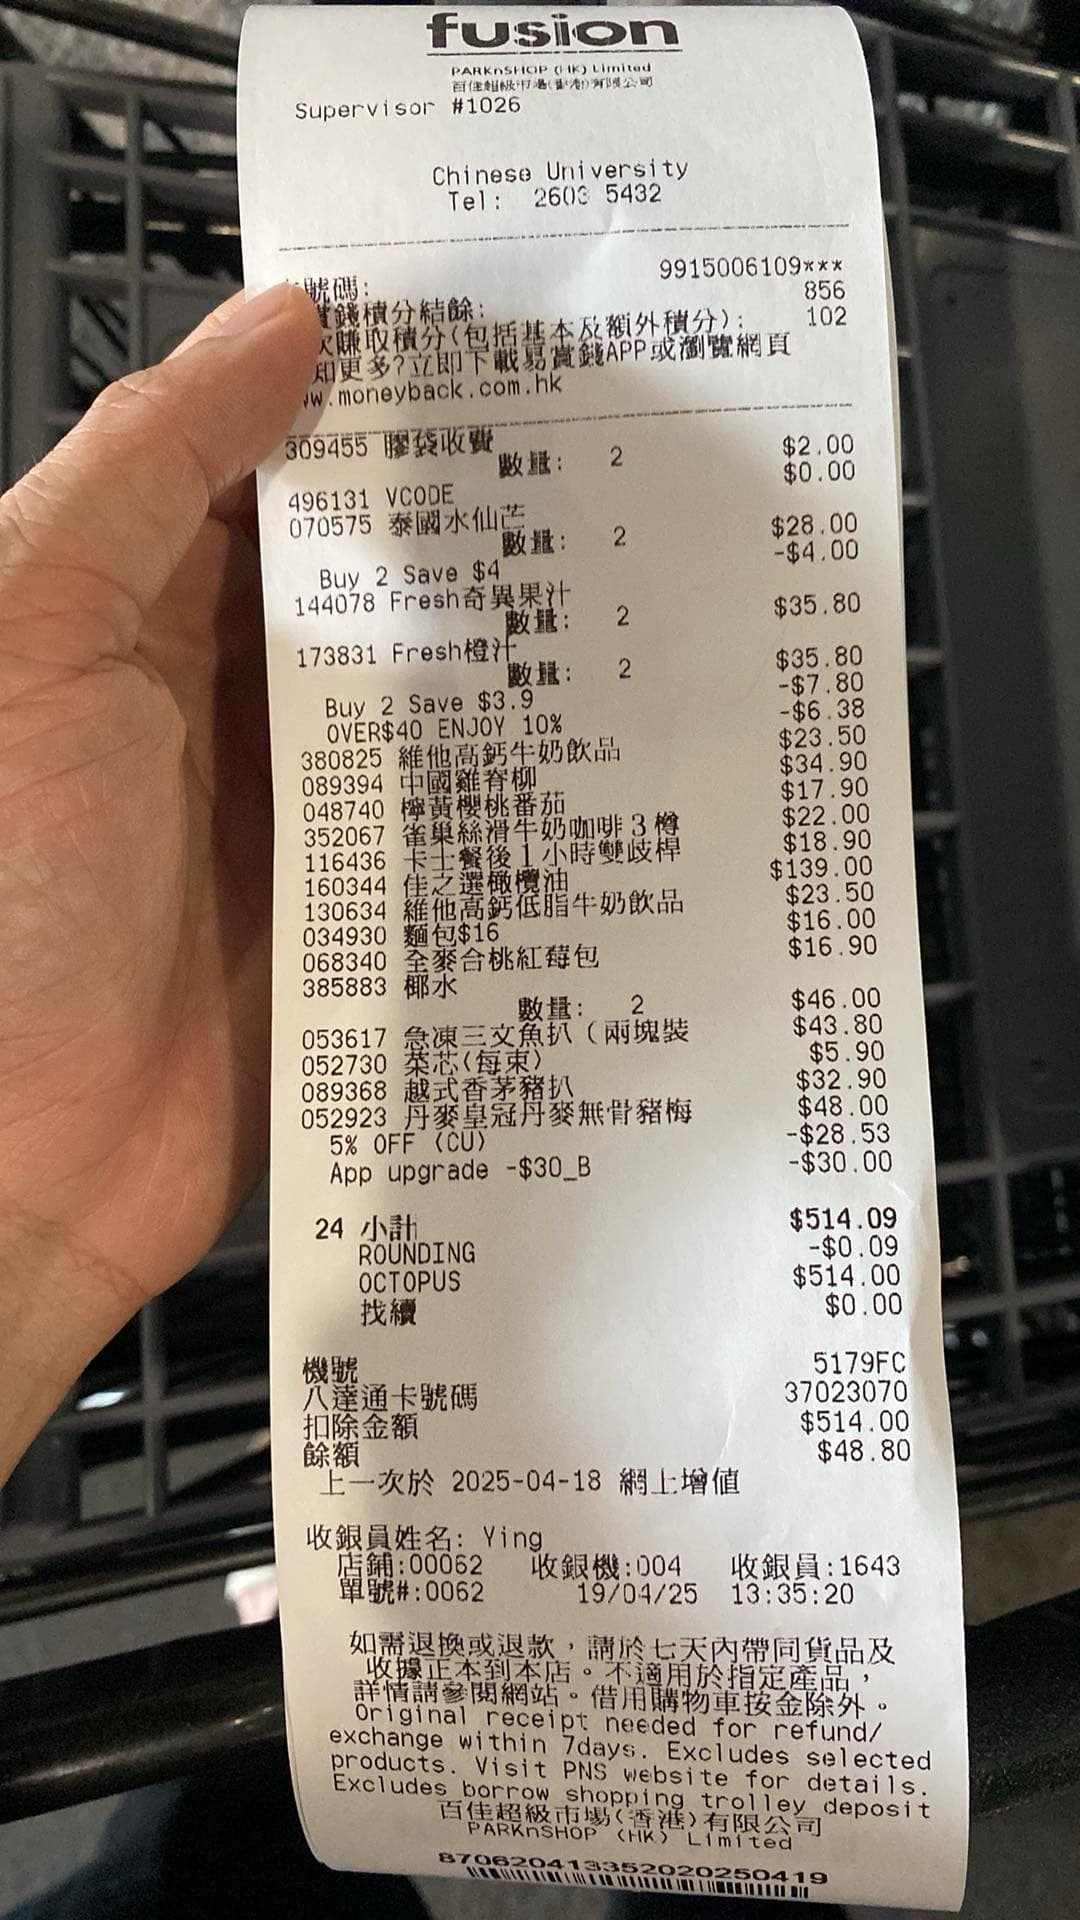
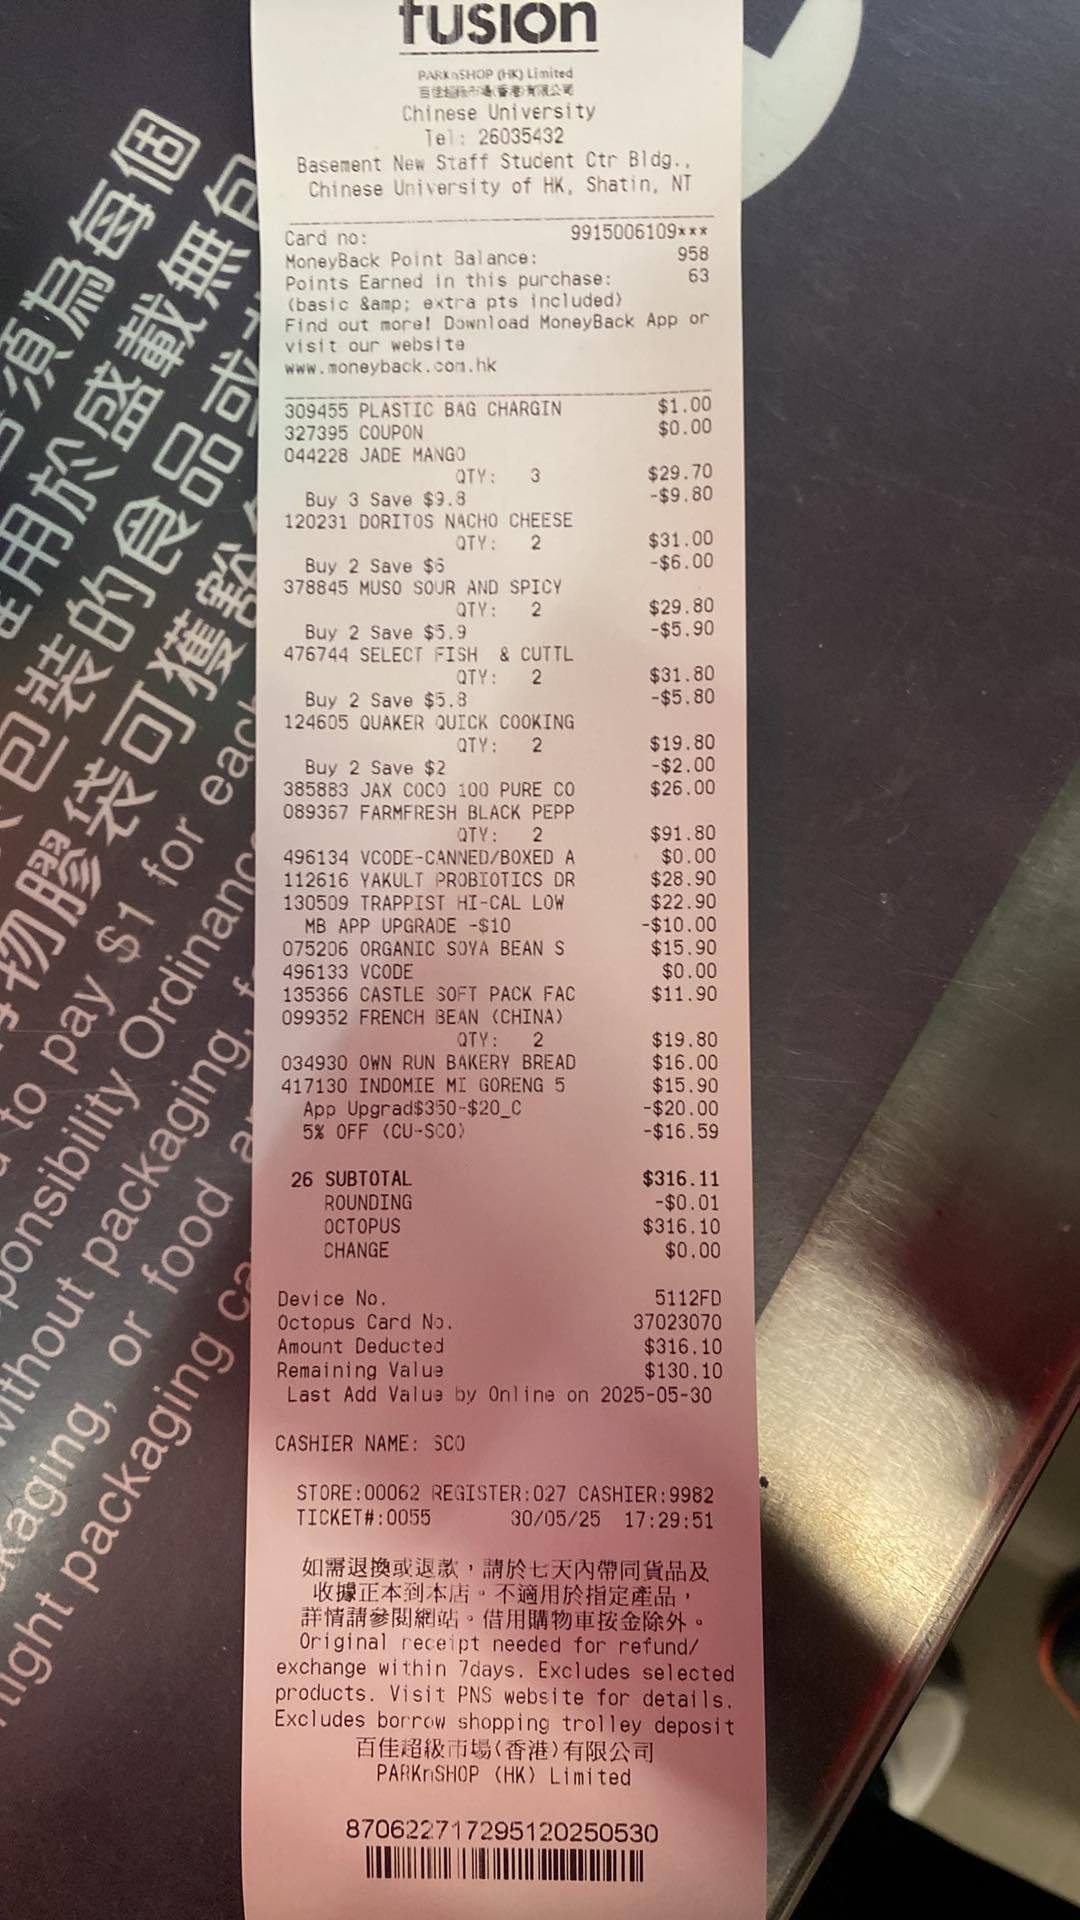
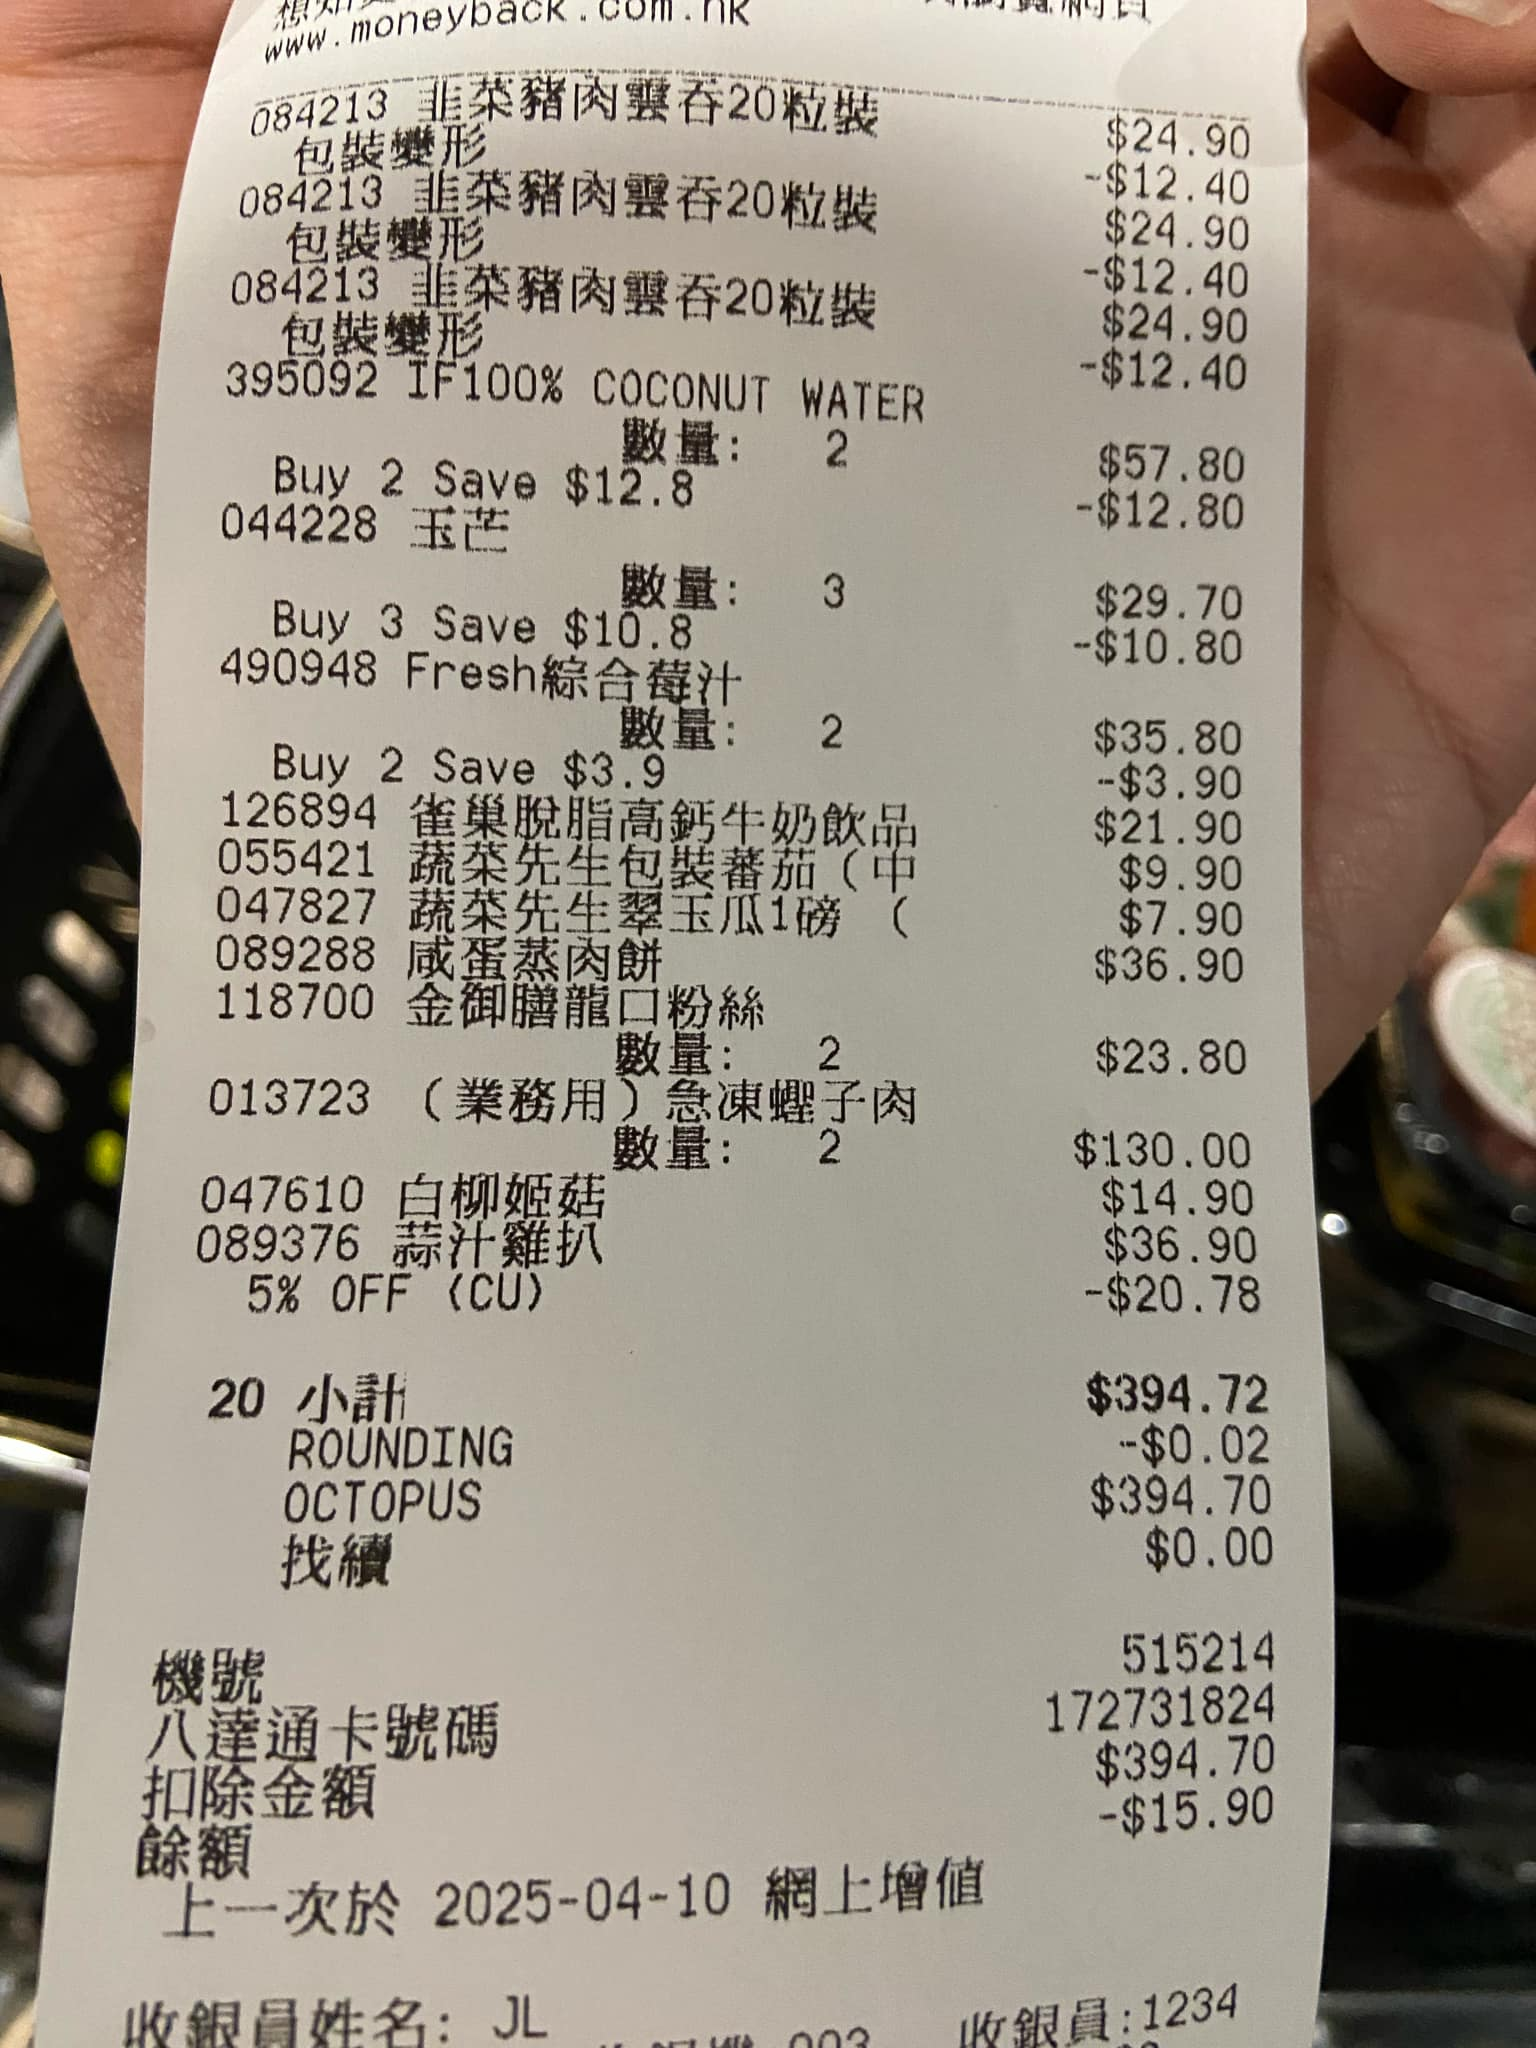

In [14]:
from IPython.display import HTML, display
import glob, os

image_paths = glob.glob("*.jpg")
image_paths.sort()
html_content = '<div style="display: flex; flex-wrap: wrap; gap: 20px;">'

for path in image_paths:
    b64 = image_to_base64(path)
    filename = os.path.basename(path) # Clean up path to show just the name

    # Create a vertical column for each image + text
    html_content += f'''
    <div style="display: flex; flex-direction: column; align-items: center;">
        <img src="data:image/jpeg;base64,{b64}" style="height: 300px; border: 1px solid #ddd; margin-bottom: 5px;"/>
        <span style="font-family: monospace; font-size: 14px;">{filename}</span>
    </div>
    '''

html_content += '</div>'

display(HTML(html_content))

### 2. Image input to Gemini
Different from text, image needs to be converted into base64 encoded string and then formated into url before inputting to the language model. This is convenient for image-type input to be transfered through the API.

You can find out more appropriate format for image-type data in this [Link](https://docs.langchain.com/oss/python/langchain/messages)



In [15]:
image_path = "/content/receipt1.jpg"
image_data_url = get_image_data_url(image_path)

In [16]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant."),
    ("human", [
        {"type": "text", "text": "{question}"},
        {"type": "image_url", "image_url": {"url": "{image_url}"}},
    ]),
])

chain = prompt | llm

response = chain.invoke({
    "question": "What is in this picture?",
    "image_url": image_data_url  # Pass the full data URI here
})

print(response.content)

This picture shows a **receipt from a "fusion" supermarket (part of PARKNSHOP (HK) Limited)**, held by a person's hand.

Here's a detailed breakdown of what's visible on the receipt:

**Store Information:**
*   **Store Name:** fusion (PARKNSHOP (HK) Limited)
*   **Supervisor ID:** #1026
*   **Location:** Chinese University
*   **Telephone:** 2603 5432

**Transaction Details:**
*   **Date and Time:** 19/04/25 (April 19, 2025) at 13:35:20 (1:35 PM and 20 seconds)
*   **Cashier Name:** Ying
*   **Store ID:** 00062
*   **Cash Register:** 004
*   **Cashier ID:** 1643
*   **Receipt Number:** 0062

**Purchased Items and Prices (in HKD):**
The receipt lists a variety of groceries, including:
*   Plastic bag charge (2 @ $1.00 each) - $2.00
*   VCODE (likely a coupon/discount code) - $0.00
*   Thai Mango (2 units) - $28.00 (with a "Buy 2 Save $4" discount)
*   Fresh Kiwi Juice (2 units) - $35.80
*   Fresh Orange Juice (2 units) - $35.80 (with a "Buy 2 Save $3.9" discount)
*   "OVER$40 ENJOY 10%"

In [17]:
from langchain_core.prompts import ChatPromptTemplate

def extract_financial_info_from_receipts(image_paths):
    extracted_data = []
    for image_path in image_paths:
        image_data_url = get_image_data_url(image_path)

        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an expert at extracting financial information from receipts. Always provide the extracted information in a clear JSON format. If a piece of information is not found, use null."),
            ("human", [
                {"type": "text", "text": "Extract the following information from the receipt: total paid, subtotal, and any discount amounts. Present the output as a JSON object with keys 'total_paid', 'subtotal', and 'discounts'. If multiple discounts are present, list them in an array. If no discounts, use an empty array. If a field is not found, set its value to null."},
                {"type": "image_url", "image_url": {"url": "{image_url}"}},
            ]),
        ])

        chain = prompt | llm

        response = chain.invoke({
            "image_url": image_data_url
        })
        extracted_data.append(response.content)
    return extracted_data


Defined function 'extract_financial_info_from_receipts' to process receipt images.


In [18]:
image_paths = glob.glob("*.jpg")
image_paths.sort()
extracted_financial_data = extract_financial_info_from_receipts(image_paths)

import json
for i, data_str in enumerate(extracted_financial_data):
    print(f"\n--- Data for {image_paths[i]} ---")
    try:
        # Attempt to parse as JSON for better readability
        parsed_data = json.loads(data_str)
        print(json.dumps(parsed_data, indent=2))
    except json.JSONDecodeError:
        print(data_str)



--- Data for receipt1.jpg ---
```json
{
  "total_paid": 514.00,
  "subtotal": 514.09,
  "discounts": [
    4.00,
    7.80,
    6.38,
    28.53,
    30.00
  ]
}
```

--- Data for receipt2.jpg ---
```json
{
  "total_paid": 316.10,
  "subtotal": 316.11,
  "discounts": [
    9.80,
    6.00,
    5.90,
    5.80,
    2.00,
    10.00,
    20.00,
    16.59
  ]
}
```

--- Data for receipt3.jpg ---
```json
{
  "total_paid": 394.70,
  "subtotal": 394.72,
  "discounts": [
    12.40,
    12.40,
    12.40,
    12.80,
    10.80,
    3.90,
    20.78,
    15.90
  ]
}
```


In [19]:
import json

def parse_financial_data(raw_json_string):
    if raw_json_string.startswith('```json') and raw_json_string.endswith('```'):
        json_str = raw_json_string[7:-3].strip()
    else:
        json_str = raw_json_string.strip()

    try:
        parsed_dict = json.loads(json_str)
    except json.JSONDecodeError:
        print(f"Error decoding JSON: {json_str}")
        return {"total_paid": 0.0, "subtotal": 0.0, "discounts": []}

    total_paid = float(parsed_dict.get('total_paid', 0.0)) if parsed_dict.get('total_paid') is not None else 0.0
    subtotal = float(parsed_dict.get('subtotal', 0.0)) if parsed_dict.get('subtotal') is not None else 0.0

    discounts_raw = parsed_dict.get('discounts', [])
    discounts = []
    if isinstance(discounts_raw, list):
        for d in discounts_raw:
            try:
                discounts.append(float(d))
            except (ValueError, TypeError):
                continue

    return {
        "total_paid": total_paid,
        "subtotal": subtotal,
        "discounts": discounts
    }

parsed_receipts_data = [parse_financial_data(data_str) for data_str in extracted_financial_data]

for i, data in enumerate(parsed_receipts_data):
    print(f"\n--- Parsed Data for receipt {i+1} ---")
    print(json.dumps(data, indent=2))


--- Parsed Data for receipt 1 ---
{
  "total_paid": 514.0,
  "subtotal": 514.09,
  "discounts": [
    4.0,
    7.8,
    6.38,
    28.53,
    30.0
  ]
}

--- Parsed Data for receipt 2 ---
{
  "total_paid": 316.1,
  "subtotal": 316.11,
  "discounts": [
    9.8,
    6.0,
    5.9,
    5.8,
    2.0,
    10.0,
    20.0,
    16.59
  ]
}

--- Parsed Data for receipt 3 ---
{
  "total_paid": 394.7,
  "subtotal": 394.72,
  "discounts": [
    12.4,
    12.4,
    12.4,
    12.8,
    10.8,
    3.9,
    20.78,
    15.9
  ]
}


In [20]:
def get_total_spent(data):
    total_spent = 0.0
    for receipt in data:
        total_spent += receipt.get('total_paid', 0.0)
    return total_spent

def get_total_without_discounts(data):
    total_without_discounts = 0.0
    for receipt in data:
        current_total_paid = receipt.get('total_paid', 0.0)
        current_discounts_sum = sum(receipt.get('discounts', []))
        total_without_discounts += (current_total_paid + current_discounts_sum)
    return total_without_discounts

total_spent_all_receipts = get_total_spent(parsed_receipts_data)
total_without_discounts_all_receipts = get_total_without_discounts(parsed_receipts_data)

print(f"Total money spent across all receipts: {total_spent_all_receipts:.2f}")
print(f"Total money without discounts across all receipts: {total_without_discounts_all_receipts:.2f}")

Total money spent across all receipts: 1224.80
Total money without discounts across all receipts: 1478.98


In [21]:
def classify_query(query_text):
    valid_queries = {
        "how much money did i spend in total for these bills?": "total_spent_query",
        "how much would i have had to pay without the discount?": "total_without_discount_query",
    }
    normalized_query = query_text.lower().strip()

    return valid_queries.get(normalized_query, "irrelevant_query")


--- Testing Query Classifier ---
Query: 'How much money did I spend in total for these bills?' -> Classification: total_spent_query
Query: '  How much would I have had to pay without the discount?' -> Classification: total_without_discount_query
Query: 'What is the weather like today?' -> Classification: irrelevant_query
Query: 'Tell me about the discounts on receipt1.jpg' -> Classification: irrelevant_query


In [22]:
def process_receipt_queries(image_paths, user_query):
    extracted_financial_data = extract_financial_info_from_receipts(image_paths)
    parsed_receipts_data = [parse_financial_data(data_str) for data_str in extracted_financial_data]
    query_type = classify_query(user_query)
    if query_type == "total_spent_query":
        total_spent = get_total_spent(parsed_receipts_data)
        return f"Total money spent across all receipts: {total_spent:.2f}"
    elif query_type == "total_without_discount_query":
        total_without_discounts = get_total_without_discounts(parsed_receipts_data)
        return f"Total money without discounts across all receipts: {total_without_discounts:.2f}"
    elif query_type == "irrelevant_query":
        return "This query cannot be processed. Please ask about total money spent or total without discounts."
    else:
        return "An unexpected error occurred with query classification."

Defined function 'process_receipt_queries' to handle integrated receipt processing and query answering.


In [23]:
image_paths = glob.glob("*.jpg")
image_paths.sort()

valid_query_1 = "How much money did I spend in total for these bills?"
response_1 = process_receipt_queries(image_paths, valid_query_1)
print(f"\nQuery: '{valid_query_1}'")
print(f"Response: {response_1}")

valid_query_2 = "How much would I have had to pay without the discount?"
response_2 = process_receipt_queries(image_paths, valid_query_2)
print(f"\nQuery: '{valid_query_2}'")
print(f"Response: {response_2}")

irrelevant_query = "What was the weather like on the day of receipt1.jpg?"
response_3 = process_receipt_queries(image_paths, irrelevant_query)
print(f"\nQuery: '{irrelevant_query}'")
print(f"Response: {response_3}")

irrelevant_query_2 = "List all items purchased on receipt2.jpg."
response_4 = process_receipt_queries(image_paths, irrelevant_query_2)
print(f"\nQuery: '{irrelevant_query_2}'")
print(f"Response: {response_4}")

--- Testing 'process_receipt_queries' function ---

Query: 'How much money did I spend in total for these bills?'
Response: Total money spent across all receipts: 1224.80

Query: 'How much would I have had to pay without the discount?'
Response: Total money without discounts across all receipts: 1478.98

Query: 'What was the weather like on the day of receipt1.jpg?'
Response: This query cannot be processed. Please ask about total money spent or total without discounts.

Query: 'List all items purchased on receipt2.jpg.'
Response: This query cannot be processed. Please ask about total money spent or total without discounts.
